#**Importing Dependencies and Dataset**

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image
from sklearn.model_selection import train_test_split

In [ ]:
!kaggle datasets download -d anthonytherrien/dog-vs-cat

Dataset URL: https://www.kaggle.com/datasets/anthonytherrien/dog-vs-cat
License(s): CC-BY-SA-4.0
dog-vs-cat.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
# Path to the zip file
zip_file_path = "/content/dog-vs-cat.zip"


# We extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("/content/Cat_Dogs_Data")

In [ ]:
#Get the paths for all the cat images
cat_filenames = []
for i in os.listdir("/content/Cat_Dogs_Data/animals/cat"):
  cat_filenames.append("/content/Cat_Dogs_Data/animals/cat/"+i)

#Get the paths for all the dog images
dog_filenames = []
for i in os.listdir("/content/Cat_Dogs_Data/animals/dog"):
  dog_filenames.append("/content/Cat_Dogs_Data/animals/dog/"+i)

#**Here the `label-  0` is for cats and `label- 1` is for dogs.**

In [ ]:
class_names = ['Cat', 'Dog']  # 0 for Cat, 1 for Dog

In [ ]:
# Create the labels (0 for cats, 1 for dogs)
cat_labels = [0] * len(cat_filenames)
dog_labels = [1] * len(dog_filenames)

# Combine the filenames and labels
filenames = cat_filenames + dog_filenames
labels = cat_labels + dog_labels

#**Splitting data into test and train groups**

In [ ]:
# Split the data into train and test sets using sklearn's train_test_split
train_filenames, test_filenames, train_labels, test_labels = train_test_split(
    filenames, labels, test_size=0.2, random_state=42, stratify=labels)

In [ ]:
# Create a TensorFlow Dataset for training data
train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames, train_labels))

# Create a TensorFlow Dataset for testing data
test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames, test_labels))

#**Data Pre-processing and Normalization**

In [ ]:
# Function to load and preprocess the image
def load_and_preprocess_image(filename, label):
    # Load the raw data from the file as a string
    image = tf.io.read_file(filename)

    # Decode the image (the format can vary, you can also use decode_jpeg or decode_png)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)

    # Ensure image shape is defined
    image.set_shape([None, None, 3]) # set the shape dynamically

    # Resize the image to a standard shape (for example, 224x224)
    image = tf.image.resize(image, [224, 224])

    # Normalize the pixel values to the range [0, 1]
    image = image / 255.0

    return image, label

In [ ]:
# Map the function over the train and test datasets
train_dataset = train_dataset.map(load_and_preprocess_image)
test_dataset = test_dataset.map(load_and_preprocess_image)

# Shuffle, batch, and prefetch the training dataset
batch_size = 8
train_dataset = train_dataset.shuffle(buffer_size=len(train_filenames)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# Batch and prefetch the testing dataset (no need to shuffle test data)
test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

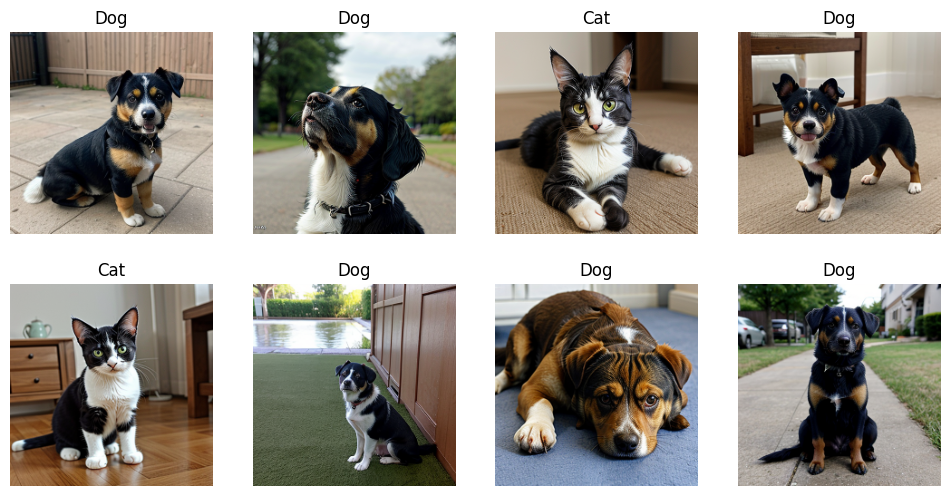

In [ ]:
image_batch, label_batch = next(iter(train_dataset))

images = image_batch.numpy()
labels = label_batch.numpy()

plt.figure(figsize=(12, 6))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.show()

In [ ]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
test_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

#**Model Architecture and Training**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Input
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image

In [ ]:
model = Sequential()
model.add(Conv2D (32, kernel_size=(3,3), activation='relu', input_shape=(224,224,3)))
model.add(Conv2D (64, (3,3), activation='relu'))
model.add(MaxPooling2D (pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D (64, (3,3), activation='relu'))
model.add(MaxPooling2D (pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D (pool_size=(2,2)))
model.add(Dropout (0.25))

model.add(Flatten())
model.add(Dense (64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense (1, activation='sigmoid'))

model.compile(loss=keras.losses.binary_crossentropy, optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 conv2d_2 (Conv2D)           (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 110, 110, 64)     0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 110, 110, 64)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 108, 108, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                  

In [ ]:
model.fit(train_dataset, steps_per_epoch=8, epochs=25)

Epoch 1/25
8/8 [==============================] - 2s 59ms/step - loss: 0.3582 - accuracy: 0.8906
Epoch 2/25
8/8 [==============================] - 0s 57ms/step - loss: 0.2433 - accuracy: 0.9219
Epoch 3/25
8/8 [==============================] - 0s 58ms/step - loss: 0.4720 - accuracy: 0.8281
Epoch 4/25
8/8 [==============================] - 0s 58ms/step - loss: 0.4217 - accuracy: 0.8594
Epoch 5/25
8/8 [==============================] - 0s 57ms/step - loss: 0.4320 - accuracy: 0.8438
Epoch 6/25
8/8 [==============================] - 0s 61ms/step - loss: 0.3393 - accuracy: 0.8125
Epoch 7/25
8/8 [==============================] - 0s 59ms/step - loss: 0.3889 - accuracy: 0.8281
Epoch 8/25
8/8 [==============================] - 0s 57ms/step - loss: 0.2981 - accuracy: 0.8438
Epoch 9/25
8/8 [==============================] - 0s 57ms/step - loss: 0.3198 - accuracy: 0.8438
Epoch 10/25
8/8 [==============================] - 0s 56ms/step - loss: 0.2568 - accuracy: 0.9062
Epoch 11/25
8/8 [============

In [ ]:
pred = model.predict(test_dataset)

25/25 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 42ms/step


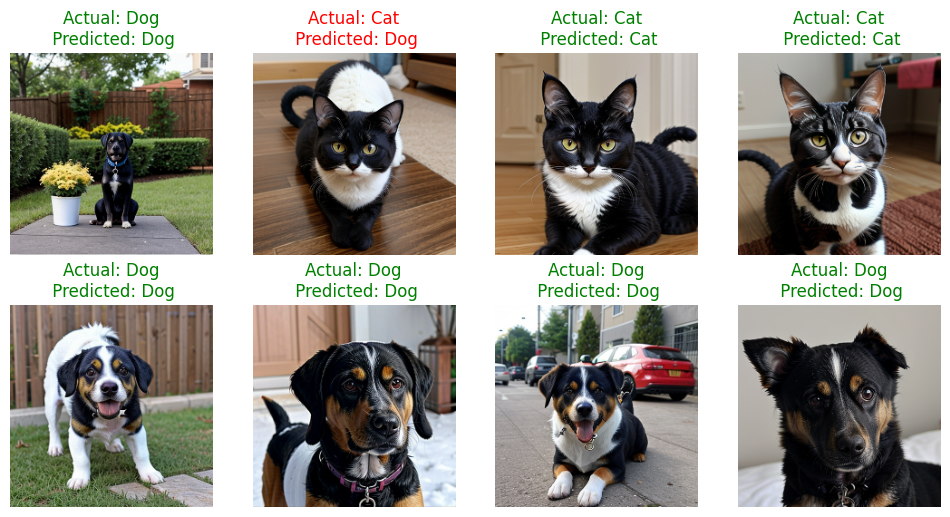

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and labels from the test dataset
image_batch, label_batch = next(iter(test_dataset))

# Get predictions for the image batch
pred_probs = model.predict(image_batch)

# Convert prediction probabilities to class labels (0 or 1)
pred_labels = (pred_probs > 0.5).astype(int)

class_names = {0: 'Cat', 1: 'Dog'}  # Replace with your actual class names

images = image_batch.numpy()
labels = label_batch.numpy()

plt.figure(figsize=(12, 6))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i])
    # Compare the actual label with the predicted label for the current image
    if class_names[labels[i]] == class_names[pred_labels[i][0]]:
        plt.title(f"Actual: {class_names[labels[i]]}\n Predicted: {class_names[pred_labels[i][0]]}", color='green')
    else:
        plt.title(f"Actual: {class_names[labels[i]]}\n Predicted: {class_names[pred_labels[i][0]]}", color='red')
    plt.axis("off")

plt.show()

#**Just for fun you can load anybody's image here for fun (Testing Model)**

1/1 [==============================] - 0s 44ms/step


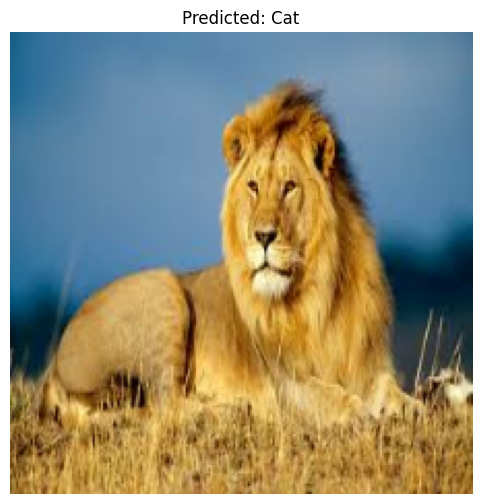

In [ ]:
image_sample = tf.io.read_file('Enter image path here')#Ensure it is in JPEG or PNG Format

image_sample = tf.image.decode_image(image_sample, channels=3, expand_animations=False)

# Ensure image shape is defined
image_sample.set_shape([None, None, 3]) # set the shape dynamically

# Resize the image to a standard shape (for example, 224x224)
image_sample = tf.image.resize(image_sample, [224, 224])

# Normalize the pixel values to the range [0, 1]
image_sample = image_sample / 255.0

# Reshape the image to add a batch dimension
image_sample = tf.expand_dims(image_sample, axis=0) # Add batch dimension

# Get predictions for the image batch
pred_probs = model.predict(image_sample)

# Convert prediction probabilities to class labels (0 or 1)
pred_labels = (pred_probs > 0.5).astype(int)

class_names = {0: 'Cat', 1: 'Dog'}  # Replace with your actual class names

images = image_sample.numpy()

plt.figure(figsize=(12, 6))

plt.imshow(images[0]) # Display the single image
plt.title(f"Predicted: {class_names[pred_labels[0][0]]}")
plt.axis("off")

plt.show()